<html>
<h3>Removing top layer of efficient net and loading our own classification layer</h3>

references:<br>
<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/">Tensorflow Documentation - Layers</a><br>
<a href="https://arxiv.org/pdf/1905.11946.pdf">Efficient Net and how it works</a><br>
<a href="https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/">Keras example for fine tuning</a><br>
<a href="https://www.tensorflow.org/guide/keras/train_and_evaluate">Tensorflow Documentation - Compiling and Evaluating</a><br>
<a href="https://keras.io/api/optimizers/">Keras Documentation - Optimisers</a><br>
<a href="https://keras.io/api/metrics/">Keras Documentation - Metrics</a><br>
<a href="https://keras.io/api/losses/">Keras Documentation - Losses</a><br>
<a href="https://keras.io/api/preprocessing/image/">Keras Documentation - Image Preprocess</a><br>
</html>

In [1]:
# importing required packages

from tensorflow.keras.applications import EfficientNetB0 as enet
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
from tensorflow.image import ResizeMethod

%matplotlib inline

In [2]:
# General Settings #
train_folder = "../data/training"
validation_folder = "../data/validation"
test_folder = "../data/test"
save_folder = "../data/saved"
height = 224
width = 224
num_train = 1600
num_valid = 400
batch_size = 20
v_batch_size = 12
epochs_to_run = 2
learning_rate = 2e-2

In [3]:
# functions parking lot
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# picture display functions for image_generators
def sample_pics(generated):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        batch = generated.next()
        ax = plt.subplot(3, 3, i + 1)
        image = batch[0][0].astype('uint8')
        plt.title(batch[1][0].astype("int"))
        plt.imshow(image)

    print("With Mask = [1 0], Without Mask = [0 1]:")
    plt.show()

In [ ]:
# to do - read and display original image from folders maybe?


In [4]:
# loading pretrained model, setting input shape
inputs = (224, 224, 3)

# Selecting a topless model (sounds damn good...)
basemodel = enet(include_top=False, input_shape=inputs, weights="imagenet")

# locking the trained weights (freezing?)
basemodel.trainable = False 

# checking out how its like
basemodel.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [5]:
# to rebuild top layer for our own classification

dropout_rate = 0.5 #i_dunno_yet - supposed to prevent overfit
types = 2 #currently only mask and no mask 

# building up the model in sequence
model = models.Sequential()

# loading the original topless model
model.add(basemodel)

# adding top layers 
model.add(layers.GlobalMaxPooling2D(name="gap"))

model.add(layers.Dropout(dropout_rate, name="drout"))

model.add(layers.Dense(types, activation="softmax", name="classdense"))

# view the assembled model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
drout (Dropout)              (None, 1280)              0         
_________________________________________________________________
classdense (Dense)           (None, 2)                 2562      
Total params: 4,052,133
Trainable params: 2,562
Non-trainable params: 4,049,571
_________________________________________________________________


Found 1600 images belonging to 2 classes.
With Mask = [1 0], Without Mask = [0 1]:


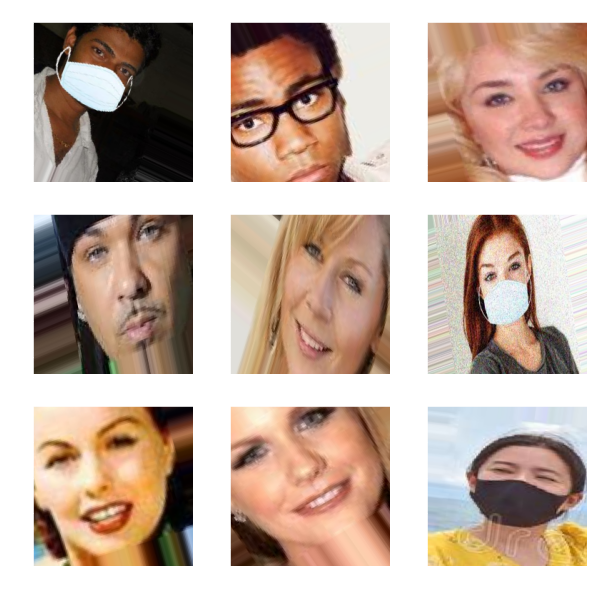

Found 400 images belonging to 2 classes.
With Mask = [1 0], Without Mask = [0 1]:


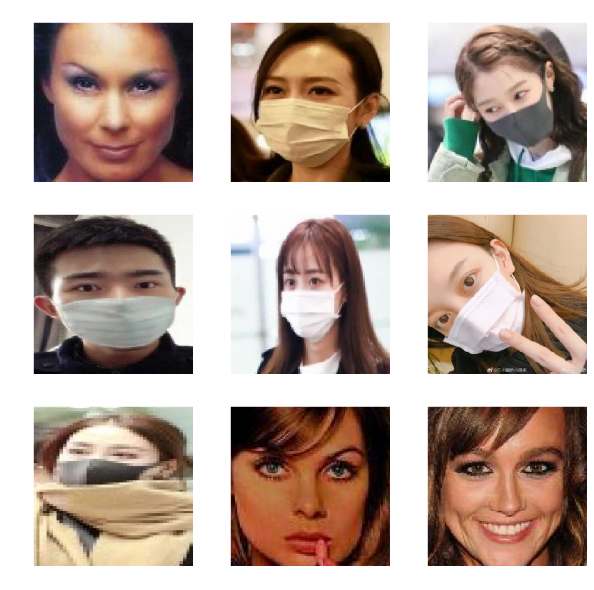

Found 102 images belonging to 2 classes.
With Mask = [1 0], Without Mask = [0 1]:


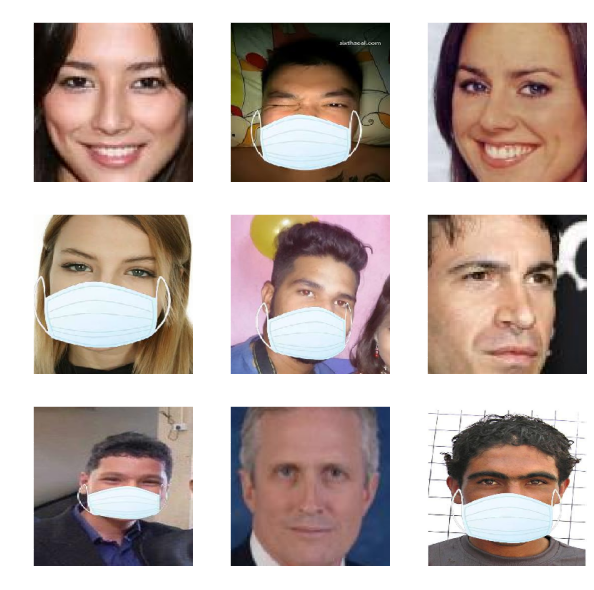

In [6]:
## Image Preprocessing ###


## Test Codes ## sharpen ## upgradeB7 #split data
train_tf = ImageDataGenerator(width_shift_range = 0.2, height_shift_range = 0.2, rotation_range = 35, #rescale = 1.0 / 255
                              shear_range = 0.2, channel_shift_range = 0.3, zoom_range = 0.3)

# using keras image generator, disable save_to_dir if not required
train_generate = train_tf.flow_from_directory(train_folder, target_size = (height, width), #save_to_dir = save_folder,
                                              shuffle = True, batch_size = batch_size, class_mode="categorical")

# Huat ah, find the explanations to DirectoryIterator find until i want to faint.
sample_pics(train_generate)

# dumping validate data into a DirectoryIterator 
validate_tf = ImageDataGenerator()#rescale = 1.0 / 255)

validate_generate = validate_tf.flow_from_directory(validation_folder, target_size = (height, width), shuffle = True,                                                                batch_size = batch_size, class_mode="categorical")

# showing in 9x9 grid
sample_pics(validate_generate)

# dumping validate data into a DirectoryIterator 
test_tf = ImageDataGenerator()#rescale = 1.0 / 255)

test_generate = test_tf.flow_from_directory(test_folder, target_size = (height, width), shuffle = True,                                                                batch_size = batch_size, class_mode="categorical")

# showing in 9x9 grid
sample_pics(test_generate)

In [16]:
# compile and train model

model.compile(loss="categorical_crossentropy", optimizer = keras.optimizers.Adam(lr=learning_rate), metrics = ["accuracy"])

history = model.fit(train_generate, epochs = epochs_to_run, batch_size = batch_size,
                    validation_data = validate_generate, validation_batch_size = v_batch_size)


Epoch 1/2
80/80 [==============================] - 47s 529ms/step - loss: 1.2338 - accuracy: 0.9671 - val_loss: 0.7635 - val_accuracy: 0.9850
Epoch 2/2
80/80 [==============================] - 41s 515ms/step - loss: 0.4477 - accuracy: 0.9852 - val_loss: 0.5032 - val_accuracy: 0.9875


In [ ]:
# to do - plot history into x-epoch, y-accuracy vs x-epoch, y-losses


In [17]:
# Evaluate Model .... then we can haolian abit 

model.evaluate(test_generate)

6/6 [==============================] - 2s 322ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

In [18]:
# to do - pack and export model for deploy/online predictions
#!pip install pyyaml h5py

model.save(save_folder)

INFO:tensorflow:Assets written to: ../data/saved\assets



def get_list(whole_list, unique, filter, list_pos):

    ret_list = []
    dsize = len(whole_list)
    
    # handle use cases
    if list_pos == 0 or list_pos > 2:
        print("Invalid parameter call - return NULL")
        return    # not needed - do nothing
    elif list_pos == 1:    # extract directories
         for record in range(0,dsize):
            item = whole_list[record][list_pos]   # list item to extract [depth,path,filename]
            if unique:   # process unique paths
                if item not in ret_list:   # check if already added
                    ret_list.append(item)
            else:
                ret_list.append(item)
    elif list_pos == 2:    # extract filenames
        for record in range(0,dsize):
            item = whole_list[record][list_pos]   # list item to extract [depth,path,filename]
            if whole_list[record][1] == filter:
                ret_list.append(item)   
    
    return ret_list


# todo - image preprocessing function (to check)

def make_tf_dataset(all_files):
    type_names = []
    tf_img_array = []

    dirlist = get_list(all_files, True, "*", 1)   # get unique directories
    
    for folder in dirlist:
        for pic in os.listdir(folder):
            image = os.path.join(folder, pic)
            image = tf.io.read_file(image)
            image = tf.io.decode_jpeg(image, channels = 3)
            image = tf.image.resize_with_crop_or_pad(image, 224, 224)
            #plt.imshow(image)
            #plt.show()
            image = tf.cast(np.array(image) / 255.0, tf.float32)
            tf_img_array.append(image)
            type_names.append(folder)
    
    type_dict = {k : v for v, k in enumerate(np.unique(type_names))}
    target_class= [type_dict[type_names[i]] for i in range(len(type_names))]
    tf_y = tf.cast(list(map(int, target_class)), tf.int32)

    # debug - print(f"dict = {type_dict}\n targetclass = {target_class}\n y= {tf_y}")
    return tf.stack(tf_img_array, axis = 0), tf_y


import os
# from itertools import groupby
# from operator import itemgetter

# You traverse the tree twice. Not really necessary. The code essentially creates a list of tuples. 
# Each tuple contains the depth, the relative path, and the filename.
# After that the list is sorted to have the deepest folder(s) first.
# Following that the code groups the files by depth and relative path. 
# it is using the groupby method of the itertools method.

def get_deepest_folders(path):

    a_files = []

    for root, dirs, files in os.walk(path):
        for file in files:
            # print("Looking at", file)
            relativePath = os.path.relpath(root, path)
            # print("In relative path", relativePath, root, path)
            if relativePath == ".":
                relativePath = ""
            a_files.append(
                (root.count(os.path.sep),
                root,
                file
                )
            )
    return a_files


def show_sample(whole_list, sampling = 0):

    # Code to display sample of the images
    if sampling <=0:
        return   # do nothing

    dirlist = get_list(whole_list, True, "*", 1)   # get directories

    foldersize = len(dirlist)
    print("There are: ", foldersize, " folders to be processed.")

    for directory in dirlist:
        print("Current directory: ", directory, "\r")
        filenames = get_list(whole_list, False, directory, 2)   # get all filenames
        
        for i in range (0,sampling): 
            pil_im = Image.open(directory + "/" + filenames[i])
            display(pil_im)
            print(filenames[i])  
    return


# setting image folder

media_folder = "../data/training"

all_files = get_deepest_folders(media_folder)

# display sample images from all subdirectories
show_sample(all_files, 3) 
 
# executing the create image function, returns two 


tf_img_array, tf_y = make_tf_dataset(all_files)

tf_y

# to compile the model (specifying optimser, loss and metrics) - I_dunno_need_adj_later

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss="sparse_categorical_crossentropy", metrics=["accuracy"])


# fitting the processed images into the model

batch_size = 32
epochs_to_run = 10

print("Fit model on training data:")
history = model.fit(tf_img_array, tf_y, batch_size = batch_size, epochs = epochs_to_run)

model.summary()